In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

In [321]:
img1 = cv2.imread('DataSets/Dataset 1/im0.png')
img2 = cv2.imread('DataSets/Dataset 1/im1.png')
im1 = img1.copy()
im2 = img2.copy()
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_gray,None)
kp2, des2 = sift.detectAndCompute(img2_gray,None)

In [322]:
K1 = np.array([[5299.313, 0, 1263.818], [0, 5299.313, 977.763], [0, 0, 1]])
K2 = np.array([[5299.313, 0, 1438.004], [0, 5299.313, 977.763], [0, 0, 1]])
baseline=177.288
#K1 = np.array([[4396.869, 0, 1353.072], [0, 4396.869, 989.702], [0, 0, 1]])
#K2 = np.array([[4396.869, 0, 1538.86], [0, 4396.869, 989.702], [0, 0, 1]])
#baseline=144.049
#K1 = np.array([[5806.559, 0, 1429.219], [0, 5806.559, 993.403], [0, 0, 1]])
#K2 = np.array([[5806.559, 0, 1543.51], [0, 5806.559, 993.403], [0, 0, 1]])
#baseline=174.019

In [323]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)
#select only 100
#good_matches = good_matches[:100]

In [324]:
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x :x.distance)
#good_matches = matches[0:100]
#good_matches = matches

In [325]:
draw_params = dict(matchColor = (0,0,255), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

In [326]:
#img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,flags=2)

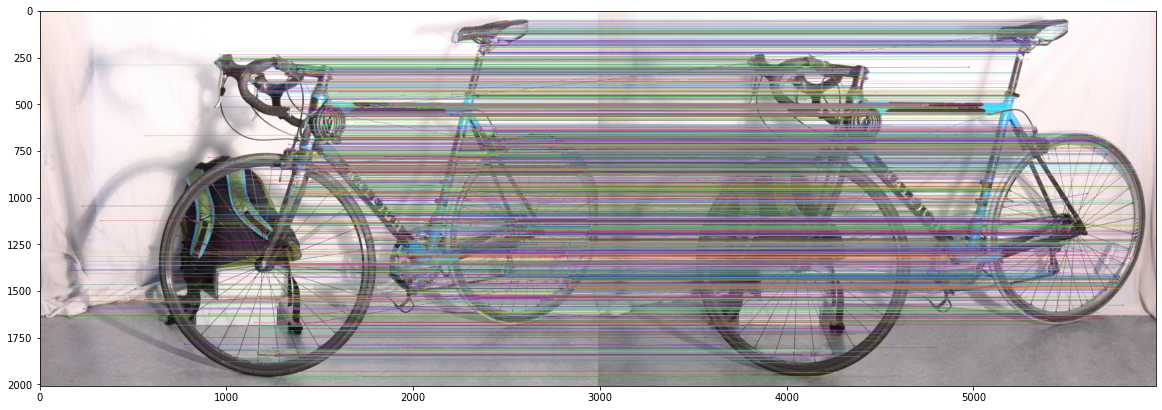

(<matplotlib.image.AxesImage at 0x7f9591bd26d8>, None)

In [327]:
plt.figure(figsize = (20,20))
plt.imshow(img3),plt.show()

In [328]:
cv2.imwrite('matches.png', img3)

True

In [329]:
matched_pairs = []
for i, m in enumerate(good_matches):
    pt1 = kp1[m.queryIdx].pt
    pt2 = kp2[m.trainIdx].pt
    matched_pairs.append([pt1[0], pt1[1], pt2[0], pt2[1]])
matched_pairs = np.array(matched_pairs).reshape(-1, 4)


In [330]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
#.reshape(-1,1,2)

In [331]:
def normalizePoints(pts):
    #calculate the mean of x and y coordinates - Compute the centroid of all corresponding points in a single image
    pts_mean = np.mean(pts, axis=0)
    x_bar = pts_mean[0]
    y_bar = pts_mean[1]

    #Recenter by subtracting the mean from original points
    x_tilda, y_tilda = pts[:,0] - x_bar, pts[:, 1] - y_bar

    #scale term s and s': average distances of the centered points from the origin in both the left and right images
    s = (2/np.mean(x_tilda**2 + y_tilda**2))**(0.5)

    #construct transformation matrix
    T_S = np.diag([s,s,1])
    T_T = np.array([[1, 0, -x_bar],[0, 1, -y_bar],[0, 0, 1]])
    T = np.dot(T_S, T_T)

    x = np.column_stack((pts, np.ones(len(pts))))
    x_norm = (T.dot(x.T)).T
    return x_norm, T

In [332]:
def getFundamentalMatrix(src, dst):
    col = 9
    # need minimum of 8 points to compute F Matrix
    if src.shape[0] > 7:
        #do normalization
        src_norm, T1 = normalizePoints(src)
        dst_norm, T2 = normalizePoints(dst)
        A = np.zeros((len(src_norm),9))

        for i in range(len(src_norm)):
            x1, y1 = src_norm[i][0], src_norm[i][1]
            x2, y2 = dst_norm[i][0], dst_norm[i][1]
            A[i] = np.array([x1*x2, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, 1])

        #calculate SVD of A
        U, S, VT = np.linalg.svd(A, full_matrices=True)
        #F = VT.T[:, -1]
        #F = F.reshape(3,3)
        F = VT[-1,:]
        F = F.reshape(3,3)

        #the calculated F matrix can be of rank 3, but to find epipolar lines, the rank should be 2.
        #thus, 
        U_, S_, VT_ = np.linalg.svd(F)
        # make diagonal matrix and set last element to 0
        S_ = np.diag(S_)
        S_[2,2] = 0
        #recompute F
        F = np.dot(U_, np.dot(S_, VT_))

        #un-normalize
        F = np.dot(T2.T, np.dot(F, T1))
        return F
    else:
        return None

In [333]:
def calculateError(x1, x2, F):
    # make x1 and x2 3*3
    x1_ = np.array([x1[0], x1[1], 1])
    x2_ = np.array([x2[0], x2[1], 1])
    #calculate the error, the ideal case should be zero for the below product
    error = np.dot(x2_.T, np.dot(F, x1_))
    return np.abs(error)

In [334]:
# https://cmsc733.github.io/2019/proj/p3/
def processInliers(src, dst):
    max_error = 0.001
    iterations = 1
    final_idx = []
    F_Matrix = None
    inliers = 0
    rows = src_pts.shape[0]
    for i in range(2000):
        temp_idx = []
        random_row = np.random.choice(rows, size=8)
        src = src_pts[random_row]
        dst = dst_pts[random_row]
        f_matrix = getFundamentalMatrix(src, dst)
        #now check the F matrix for all pairs
        for j in range(rows):
            error = calculateError(src_pts[j], dst_pts[j], f_matrix)
            if error < max_error:
                temp_idx.append(j)
        
        if len(temp_idx) > inliers:
            inliers = len(temp_idx)
            final_idx = temp_idx
            F_Matrix = f_matrix
            src_final = src_pts[final_idx]
            dst_final = dst_pts[final_idx]
    
    return F_Matrix, src_final, dst_final
    

In [335]:
F, src_final, dst_final = processInliers(src_pts, dst_pts)

In [336]:
F

array([[ 1.00309185e-11, -2.15626578e-08,  2.04788608e-05],
       [ 2.14057554e-08, -1.99727372e-10, -9.80005830e-04],
       [-2.07937498e-05,  9.78065049e-04,  2.43545271e-03]])

In [337]:
comb = np.concatenate((im1, im2), axis=1)

In [277]:
s1 = src_final[:,0].astype(int)
s2 = src_final[:,1].astype(int)
d1 = dst_final[:,0].astype(int)
d2 = dst_final[:,1].astype(int)
d1 += im1.shape[1]
for i in range(s1.shape[0]):
    cv2.line(comb, (s1[i], s2[i]), (d1[i], d2[i]), (0,0,255), 2)

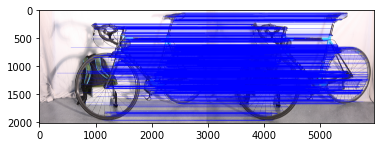

In [278]:
cv2.imwrite('temp.png', comb)
plt.imshow(comb)

## Get essential Matrix

In [279]:
def getEssentialMatrix(F, K1, K2):
    E = K2.T.dot(F).dot(K1)
    #enforce rank 2 for singular matrix
    U,S,VT = np.linalg.svd(E)
    S = np.diag([1,1,0])
    E = np.dot(U, np.dot(S, VT))
    return E

In [280]:
E = getEssentialMatrix(F, K1, K2)
E

array([[ 0.00191271, -0.68843386,  0.02433795],
       [ 0.71804958,  0.00248583,  0.69561104],
       [-0.02185782, -0.72491566,  0.00249907]])

## Estimate Pose of Camera2

In [281]:
#https://cmsc733.github.io/2019/proj/p3/
def getCameraPose(E):
    U, S, VT = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R, T = [],[]
    R.append(np.dot(U, np.dot(W, VT)))
    R.append(np.dot(U, np.dot(W, VT)))
    R.append(np.dot(U, np.dot(W.T, VT)))
    R.append(np.dot(U, np.dot(W.T, VT)))
    T.append(U[:, 2])
    T.append(-U[:, 2])
    T.append(U[:, 2])
    T.append(-U[:, 2])

    # R should always be positive
    for i in range(len(R)):
        if (np.linalg.det(R[i]) < 0):
            R[i] = -R[i]
            T[i] = -T[i]
    
    return R, T

In [282]:
R2, T2 = getCameraPose(E)

## Estimate 3D points

In [283]:
pts_3D = []
#reference Rotation, Translation and Projection matrix-
R1 = np.identity(3)
T1 = np.zeros((3,1))
I = np.identity(3)
P1 = np.dot(K1, np.dot(R1, np.hstack((I, -T1.reshape(3,1)))))

for i in range(len(R2)):
    P2 = np.dot(K2, np.dot(R2[i], np.hstack((I, -T2[i].reshape(3,1)))))
    X_3D = cv2.triangulatePoints(P1, P2, src_final.T, dst_final.T)
    pts_3D.append(X_3D)

In [284]:
# project 3D points on image
k = 0
P2 = np.dot(K2, np.dot(R2[k], np.hstack((I, -T2[k].reshape(3,1)))))

X = pts_3D[k]
x_ = np.dot(P2, X)
x_ = x_/x_[2,:]

x = x_[0, :].T
y = x_[1, :].T

im = im1.copy()
for i in range(src_final.shape[0]):

    x1, y1 = x[i], y[i]
    x2, y2 = dst_final[i][0], dst_final[i][1]
    cv2.circle(im, (int(x1), int(y1)), 10, (0,0,255), 10)
    cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), 3)

cv2.imwrite("im.png", im)

True

## Get the correct Rotation and Translation Matrix

In [285]:
def getCorrectPose(pts_3D, R1, T1, R2, T2):
    num_Z_positive = 0
    zList = []
    for k in range (len(pts_3D)):
        num_Z_positive = 0
        pts3D = pts_3D[k]
        #normalize
        pts3D = pts3D/pts3D[3, :]

        P_2 = np.dot(R2[k], np.hstack((I, -T2[k].reshape(3,1))))
        P_2 = np.vstack((P_2, np.array([0,0,0,1]).reshape(1,4)))

        P_1 = np.dot(R1, np.hstack((I, -T1.reshape(3,1))))
        P_1 = np.vstack((P_1, np.array([0,0,0,1]).reshape(1,4)))

        for i in range(pts3D.shape[1]):
            #calculate point for Right image
            X_2 = pts3D[:,i]
            X_2 = X_2.reshape(4,1)
            Xc_2 = np.dot(P_2, X_2)
            Xc_2 = Xc_2 / Xc_2[3]
            z_2 = Xc_2[2]

            #calcuate points for Left image
            X_1 = pts3D[:,i]
            X_1 = X_1.reshape(4,1)
            Xc_1 = np.dot(P_1, X_1)
            Xc_1 = Xc_1 / Xc_1[3]
            z_1 = Xc_1[2]

            if (z_1 > 0 and z_2 > 0):
                num_Z_positive += 1

        #plot the 3D points
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(pts3D[0,:], pts3D[1,:], pts3D[2,:], linewidth=0.5)

        print(num_Z_positive)
        zList.append(num_Z_positive)

        # get the correct camera pose index - define threshold for points as half the number of points
        threshold = pts_3D[0].shape[1]//2
        zArray = np.array(zList)
        index = np.where(zArray > threshold)

    return index

0
0
2052
4
2


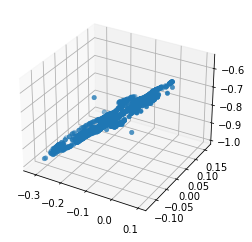

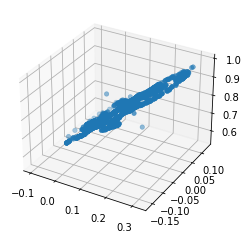

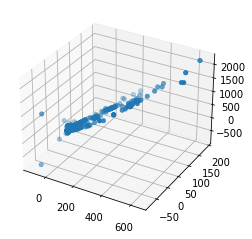

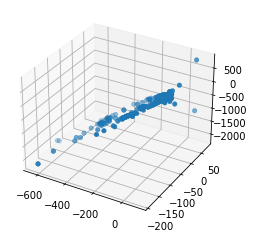

In [286]:
correct_index = (getCorrectPose(pts_3D, R1, T1, R2, T2))[0][0]
print(correct_index)

In [287]:
R2_final = R2[correct_index]
T2_final = T2[correct_index]

## epipolar lines


In [288]:
R2_final, T2_final

(array([[ 0.99913309,  0.00130493, -0.04160964],
        [-0.00139492,  0.99999675, -0.00213367],
        [ 0.04160672,  0.00218986,  0.99913167]]),
 array([ 0.72488815, -0.02288882, -0.68848622]))

In [289]:
def getEpipolarLines(src_final, dst_final, F, im1_epipolar, im2_epipolar, rectified=False):
    lines1, lines2 = [], []
    for i in range(len(src_final)):
        #arrange the source and destination points in a 3*3 array to be multiplied with F
        x1 = np.array([src_final[i,0], src_final[i,1], 1]).reshape(3,1)
        x2 = np.array([dst_final[i,0], dst_final[i,1], 1]).reshape(3,1)

        #epipolar line 1 coefficients - left image
        line1 = np.dot(F.T, x2)
        lines1.append(line1)

        #epipolar line 2 coefficients - right image
        line2 = np.dot(F, x1)
        lines2.append(line2)

        if (not rectified):
            #get the x and y values - lines are not parallel to x axis
            x1_low = 0
            x1_high = im1_epipolar.shape[1] - 1
            y1_low = -(line1[2] + x1_low*line1[0])/line1[1]
            y1_high = -(line1[2] + x1_high*line1[0])/line1[1]

            x2_low = 0
            x2_high = im2_epipolar.shape[1] - 1
            y2_low = -(line2[2] + x2_low*line2[0])/line2[1]
            y2_high = -(line2[2] + x2_high*line2[0])/line2[1]
        
        else:
            # as the lines are parallel to the X axis, the slope tends to zero
            x1_low = 0
            x1_high = im1_epipolar.shape[1] - 1
            y1_low = -(line1[2]/line1[1])
            y1_high = y1_low

            x2_low = 0
            x2_high = im2_epipolar.shape[1] - 1
            y2_low = -(line2[2]/line2[1])
            y2_high = y2_low

        #print the points onto image
        cv2.circle(im1_epipolar, (int(src_final[i,0]), int(src_final[i,1])), 5, (0,0,255), 2)
        im1_epipolar = cv2.line(im1_epipolar, (int(x1_low), int(y1_low)), (int(x1_high), int(y1_high)), (0,255,0), 1)

        cv2.circle(im2_epipolar, (int(dst_final[i,0]), int(dst_final[i,1])), 5, (0,0,255), 2)
        im2_epipolar = cv2.line(im2_epipolar, (int(x2_low), int(y2_low)), (int(x2_high), int(y2_high)), (0,255,0), 1)

    combined = np.concatenate((im1_epipolar, im2_epipolar), axis=1)
    temp = cv2.resize(combined, (1200,700))
    cv2.imshow('epilines', temp)
    cv2.imwrite('Epilines_.png', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return lines1, lines2, combined

In [290]:
lines1, lines2, epipolarLinesCombined = getEpipolarLines(src_final, dst_final, F, im1.copy(), im2.copy())

True

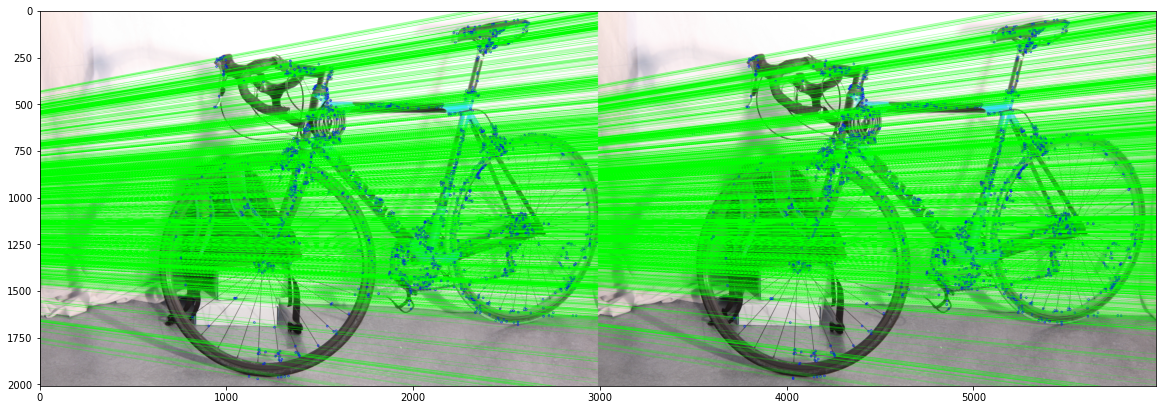

In [291]:
plt.figure(figsize = (20,20))
plt.imshow(epipolarLinesCombined)
cv2.imwrite('Epipolar_combined.png',epipolarLinesCombined)

## Image and Epilines rectification

H1 =  [[-9.64573443e-04 -1.30131262e-05  9.52292479e-02]
 [ 2.14913024e-05 -9.78312912e-04 -3.41366863e-02]
 [ 2.21397949e-08 -2.33956376e-10 -1.01358530e-03]]
H2 =  [[ 9.65933578e-01 -1.18587184e-03  5.20858492e+01]
 [-2.16651644e-02  1.00002735e+00  3.23402944e+01]
 [-2.28016519e-05  2.79934744e-08  1.03403756e+00]]


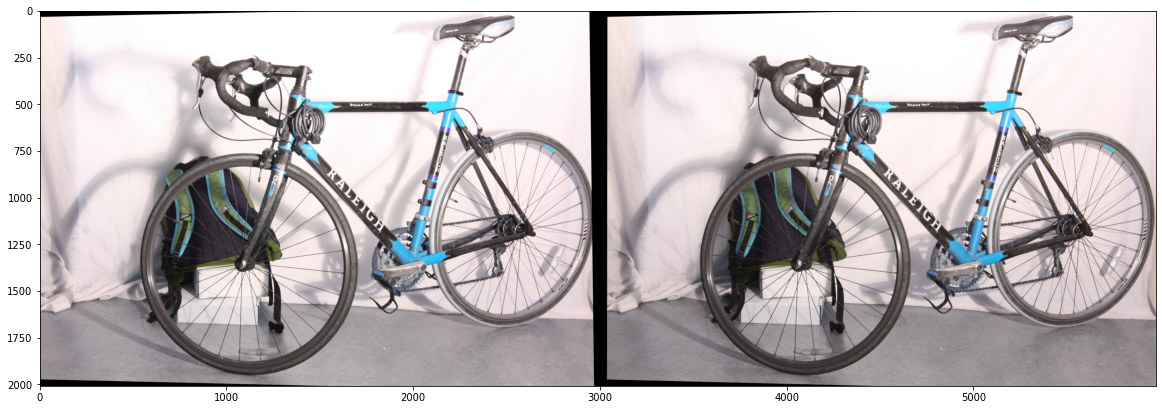

In [340]:
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(src_final), np.float32(dst_final), F, imgSize=im.shape[1::-1])
img1_rectified = cv2.warpPerspective(im1, H1, im.shape[1::-1])
img2_rectified = cv2.warpPerspective(im2, H2, im.shape[1::-1])
combined = np.concatenate((img1_rectified, img2_rectified), axis=1)
cv2.imwrite('Rectified Combined.png', combined)
plt.figure(figsize = (20,20))
plt.imshow(combined)
print('H1 = ',H1)
print('H2 = ',H2)

In [308]:
src_final_rectified = cv2.perspectiveTransform(src_final.reshape(-1, 1, 2), H1).reshape(-1,2)
dst_final_rectified = cv2.perspectiveTransform(dst_final.reshape(-1, 1, 2), H2).reshape(-1,2)

im1_rectified_with_pts = img1_rectified.copy()
im2_rectified_with_pts = img2_rectified.copy()

im1_rectified = img1_rectified.copy()
im2_rectified = img2_rectified.copy()

for i in range(src_final_rectified.shape[0]):
    cv2.circle(im1_rectified_with_pts, (int(src_final_rectified[i,0]), int(src_final_rectified[i,1])), 10, (0,0,255), 2)
    cv2.circle(im2_rectified_with_pts, (int(dst_final_rectified[i,0]), int(dst_final_rectified[i,1])), 10, (0,0,255), 2)
cv2.imwrite('Rectified_img1_with_Points.png', im1_rectified_with_pts)
cv2.imwrite('Rectified_img2_with_Points.png', im2_rectified_with_pts)
cv2.imwrite('Rectified_img1.png', im1_rectified)
cv2.imwrite('Rectified_img2.png', im2_rectified)

True

In [309]:
H2_T_inv =  np.linalg.inv(H2.T)
H1_inv = np.linalg.inv(H1)
F_rectified = np.dot(H2_T_inv, np.dot(F, H1_inv))

In [313]:
img1_rectified_epipolar = im1_rectified.copy()
img2_rectified_epipolar = im2_rectified.copy()

lines1_rectified, lines2_rectified, epipolarLinesCombined_rectified = getEpipolarLines(src_final_rectified, dst_final_rectified, F_rectified, img1_rectified_epipolar, img2_rectified_epipolar, True)

In [311]:
img1_rectified_epipolar.shape

(2008, 2988, 3)

In [312]:
img1_rectified_epipolar = cv2.resize(im1_rectified, (960,660))
img2_rectified_epipolar = cv2.resize(im2_rectified, (960,660))
cv2.imwrite('temp1.png', img1_rectified_epipolar)
cv2.imwrite('temp2.png', img2_rectified_epipolar)

True

In [298]:
img1_rectified_reshaped = cv2.cvtColor(im1_rectified, cv2.COLOR_BGR2GRAY)
img1_rectified_reshaped = cv2.resize(img1_rectified_reshaped, (600,400))
img2_rectified_reshaped = cv2.cvtColor(im2_rectified, cv2.COLOR_BGR2GRAY)
img2_rectified_reshaped = cv2.resize(img2_rectified_reshaped, (600,400))

In [52]:
from PIL import Image
from tqdm import *

def stereo_match(left_img, right_img, kernel, max_offset):
    # Load in both images, assumed to be RGBA 8bit per channel images
    left_img = Image.open(left_img).convert('L')
    left = np.asarray(left_img)
    right_img = Image.open(right_img).convert('L')
    right = np.asarray(right_img)    
    w, h = left_img.size  # assume that both images are same size   
    
    # Depth (or disparity) map
    depth = np.zeros((w, h), np.uint8)
    depth.shape = h, w
       
    kernel_half = int(kernel / 2)    
    offset_adjust = 255 / max_offset  # this is used to map depth map output to 0-255 range
      
    for y in tqdm(range(kernel_half, h - kernel_half)):      
        print(".", end="", flush=True)  # let the user know that something is happening (slowly!)
        
        for x in range(kernel_half, w - kernel_half):
            best_offset = 0
            prev_ssd = 65534
            
            for offset in range(max_offset):               
                ssd = 0
                ssd_temp = 0                            
                
                # v and u are the x,y of our local window search, used to ensure a good 
                # match- going by the squared differences of two pixels alone is insufficient, 
                # we want to go by the squared differences of the neighbouring pixels too
                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                        # iteratively sum the sum of squared differences value for this block
                        # left[] and right[] are arrays of uint8, so converting them to int saves
                        # potential overflow, and executes a lot faster 
                        ssd_temp = int(left[y+v, x+u]) - int(right[y+v, (x+u) - offset])  
                        ssd += ssd_temp * ssd_temp              
                
                # if this value is smaller than the previous ssd at this block
                # then it's theoretically a closer match. Store this value against
                # this block..
                if ssd < prev_ssd:
                    prev_ssd = ssd
                    best_offset = offset
                            
            # set depth output for this x,y location to the best match
            depth[y, x] = best_offset * offset_adjust
                                
    # Convert to PIL and save it
    Image.fromarray(depth).save('depth.png')
    return depth


In [53]:
depth = stereo_match('temp1.png', 'temp2.png', 10, 30)

  0%|          | 2/650 [00:11<1:01:02,  5.65s/it]


KeyboardInterrupt: 

In [299]:
import math
from tqdm import *
def SSD(mat1, mat2):
    diff_sq = np.square(mat1 - mat2)
    ssd = np.sum(diff_sq)
    return ssd

def SAD(mat1, mat2):
    return np.sum(abs(mat1 - mat1))

h, w = img1_rectified_reshaped.shape
disparity = np.zeros((h, w), np.uint8)
window_size = 11
half_window_size = math.floor((window_size)/2)
search_distance = 200

for r in tqdm(range(half_window_size, h -  half_window_size)): 
    for c in range(half_window_size, w -  half_window_size):
        patch1 = img1_rectified_reshaped[r - half_window_size: r + half_window_size, c - half_window_size : c + half_window_size]

        min_ssd = 10000
        dispar = 0
        #scan along epiline till a particular length
        for distance in range(-search_distance, search_distance, 1): #bidirectional
            c_dash = c + distance
            # print(c_dash)
            if (c_dash < w - half_window_size) and (c_dash > half_window_size):
                patch2 = img2_rectified_reshaped[r - half_window_size: r + half_window_size, c_dash - half_window_size : c_dash + half_window_size]
                # if patch2.shape[1] < 4:
                #     print(r, c, c_dash)
                ssd = SSD(patch1, patch2)
                if ssd < min_ssd:
                    min_ssd = ssd
                    dispar = np.abs(distance)
        
        disparity[r, c] = dispar
        

100%|██████████| 390/390 [17:14<00:00,  2.65s/it]


In [300]:
di = disparity.copy()

In [301]:
disparity = np.uint8(disparity * (255 / np.max(disparity)))


In [302]:
cv2.imshow("a", disparity)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.imwrite('disparity_grayscale.png', disparity)

True

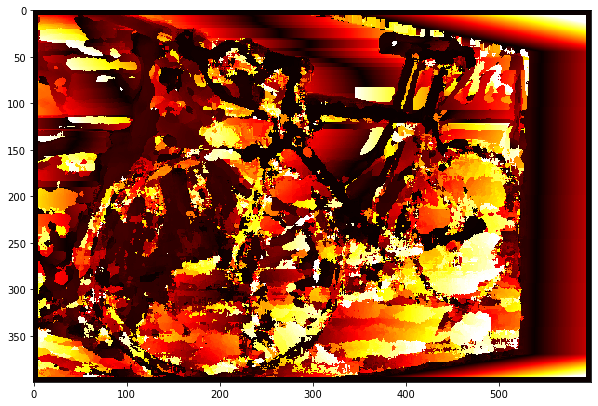

In [303]:
plt.figure(figsize=(10,10))
plt.imshow(disparity, cmap='hot',interpolation='nearest')
plt.savefig('disparity.png')

In [304]:
# depth = np.zeros((h, w))
# for i in range(h):
#     for j in range(w):
#         if (disparity[i,j] > 0):
#             depth[i,j] = (144.049 * 4.396869) / disparity[i,j]
F = K1[0][0]
depth = (baseline*F) / (disparity + 1e-15)

In [305]:
depth[depth > 100000] = 100000

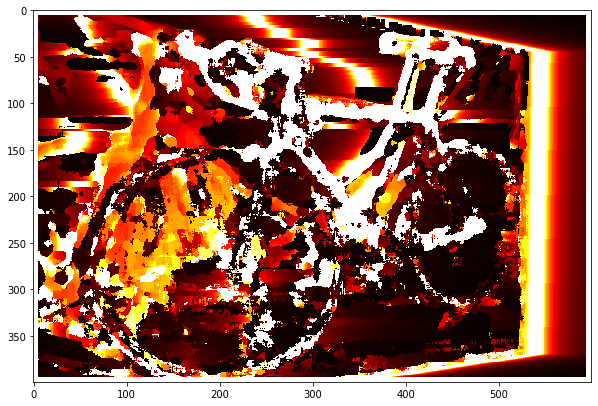

In [306]:
depth_map = np.uint8(depth * 255 / np.max(depth))
plt.figure(figsize=(10,10))
plt.imshow(depth_map, cmap='hot', interpolation='nearest')
plt.savefig('depth_image.png')
#plt.imshow(depth_map, cmap='gray', interpolation='nearest')

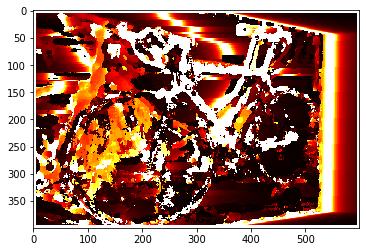

In [307]:
cv2.imshow("a", np.uint8(depth))
cv2.waitKey()
cv2.destroyAllWindows()
cv2.imwrite('depth_grayscale.png', depth)
plt.imshow(depth, cmap='hot', interpolation='nearest')

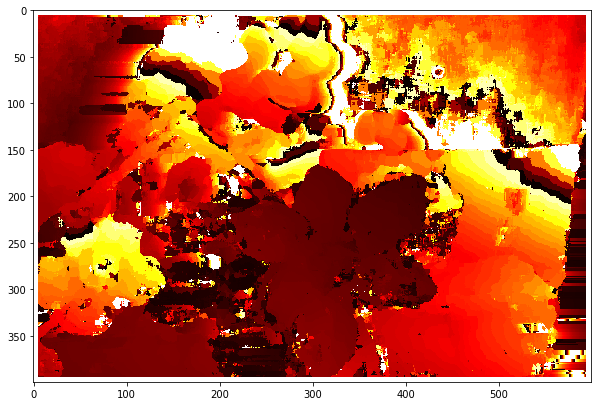

In [196]:
depth = np.uint8(500 * depth / np.max(depth))
cv2.imshow("a", np.uint8(depth))
cv2.waitKey()
cv2.destroyAllWindows()
plt.figure(figsize=(10,10))
plt.imshow(depth, cmap='hot',interpolation='nearest')

In [128]:
BLOCK_SIZE = 10
SEARCH_BLOCK_SIZE = 100

def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum(abs(pixel_vals_1 - pixel_vals_2))

def compare_blocks(y, x, block_left, right_array, block_size=5):
    # Get search range for the right image
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1], x + SEARCH_BLOCK_SIZE)
    #print(f'search bounding box: ({y, x_min}, ({y, x_max}))')
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y: y+block_size,
                                  x: x+block_size]
        sad = sum_of_abs_diff(block_left, block_right)
        #print(f'sad: {sad}, {y, x}')
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index

In [129]:
import math
h,w = img1_rectified_reshaped.shape
disparity_map = np.zeros((h, w))
for y in tqdm(range(BLOCK_SIZE, h-BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
            block_left = img1_rectified_reshaped[y:y + BLOCK_SIZE,
                                    x:x + BLOCK_SIZE]
            min_index = compare_blocks(y, x, block_left,
                                       img2_rectified_reshaped,
                                       block_size=BLOCK_SIZE)
            disparity_map[y, x] = abs(min_index[1] - x)

100%|██████████| 580/580 [14:57<00:00,  1.55s/it]


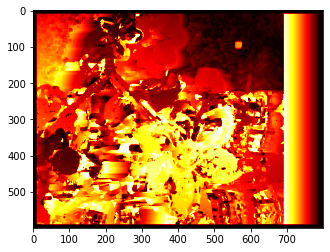

In [131]:
plt.imshow(disparity_map, cmap='hot')#, interpolation='nearest')
plt.savefig('depth_image.png')
plt.show()

In [135]:
disparity_ = np.uint8(disparity_map * (255 / np.max(disparity_map)))
cv2.imshow("a", disparity_)
cv2.waitKey()
cv2.destroyAllWindows()

In [91]:
depth = np.zeros((h, w))
for i in range(h):
    for j in range(w):
        if (disparity_[i,j] > 0):
            depth[i,j] = (144.049 * 4.396869) / disparity_[i,j]

NameError: name 'disparity_' is not defined

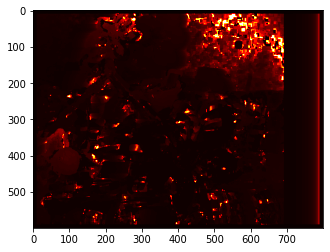

In [142]:
np.max(disparity_)
plt.imshow(depth, cmap='hot')